In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d subirbiswas19/skin-disease-dataset

100% 17.3M/17.3M [00:00<00:00, 73.8MB/s]
100% 17.3M/17.3M [00:00<00:00, 65.3MB/s]


In [3]:
!unzip -q /content/skin-disease-dataset.zip -d skin-disease

In [4]:
train_dir = '/content/skin-disease/skin-disease-datasaet/train_set'
test_dir = '/content/skin-disease/skin-disease-datasaet/test_set'

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_shape = (256, 256, 3)
num_classes = 8
batch_size = 16


CNN_Model = models.Sequential()
CNN_Model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
CNN_Model.add(layers.BatchNormalization())
CNN_Model.add(layers.MaxPooling2D(pool_size=(2,2)))
CNN_Model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
CNN_Model.add(layers.BatchNormalization())
CNN_Model.add(layers.MaxPooling2D(pool_size=(2,2)))
CNN_Model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
CNN_Model.add(layers.BatchNormalization())
CNN_Model.add(layers.MaxPooling2D(pool_size=(2,2)))
CNN_Model.add(layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
CNN_Model.add(layers.BatchNormalization())
CNN_Model.add(layers.MaxPooling2D(pool_size=(2,2)))
CNN_Model.add(layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
CNN_Model.add(layers.BatchNormalization())
CNN_Model.add(layers.MaxPooling2D(pool_size=(2,2)))
CNN_Model.add(layers.Flatten())
CNN_Model.add(layers.Dropout(0.5))
CNN_Model.add(layers.Dense(num_classes, activation='softmax'))

CNN_Model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    label_mode='categorical'
)


validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=batch_size,
    shuffle=False,
    label_mode='categorical'
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = CNN_Model.fit(train_dataset, validation_data=validation_dataset, epochs=20, callbacks=[early_stopping])


Found 924 files belonging to 8 classes.
Found 233 files belonging to 8 classes.
Epoch 1/20
58/58 [==============================] - 12s 100ms/step - loss: 2.7691 - accuracy: 0.3452 - val_loss: 1.8392 - val_accuracy: 0.3047
Epoch 2/20
58/58 [==============================] - 4s 62ms/step - loss: 1.2638 - accuracy: 0.6310 - val_loss: 1.6148 - val_accuracy: 0.3605
Epoch 3/20
58/58 [==============================] - 3s 57ms/step - loss: 0.7830 - accuracy: 0.7554 - val_loss: 1.3472 - val_accuracy: 0.4764
Epoch 4/20
58/58 [==============================] - 3s 57ms/step - loss: 0.5308 - accuracy: 0.8268 - val_loss: 1.0382 - val_accuracy: 0.6180
Epoch 5/20
58/58 [==============================] - 4s 61ms/step - loss: 0.4261 - accuracy: 0.8647 - val_loss: 0.9580 - val_accuracy: 0.6867
Epoch 6/20
58/58 [==============================] - 4s 64ms/step - loss: 0.2642 - accuracy: 0.9113 - val_loss: 0.6589 - val_accuracy: 0.8240
Epoch 7/20
58/58 [==============================] - 3s 57ms/step - loss:

In [7]:
print(f"Average Images per class Training: {924//8}, Testing: {233//8}")

Average Images per class Training: 115, Testing: 29


In [40]:
def generatorModel(latent_dim):
  generator = models.Sequential()

  generator.add(layers.Dense(32*32*180,input_dim=latent_dim))
  generator.add(layers.LeakyReLU(0.2))
  generator.add(layers.Reshape((32, 32, 180)))

  generator.add(layers.Conv2DTranspose(256, 4, 2, padding='same'))
  generator.add(layers.LeakyReLU(0.2))

  generator.add(layers.Conv2DTranspose(128, 4, 2, padding='same'))
  generator.add(layers.LeakyReLU(0.2))

  generator.add(layers.Conv2DTranspose(3, 4, 2, padding='same'))

  return generator

generator = generatorModel(128)
generator.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 184320)            23777280  
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 184320)            0         
                                                                 
 reshape_9 (Reshape)         (None, 32, 32, 180)       0         
                                                                 
 conv2d_transpose_24 (Conv2  (None, 64, 64, 256)       737536    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 64, 64, 256)       0         
                                                                 
 conv2d_transpose_25 (Conv2  (None, 128, 128, 128)     524416    
 DTranspose)                                         

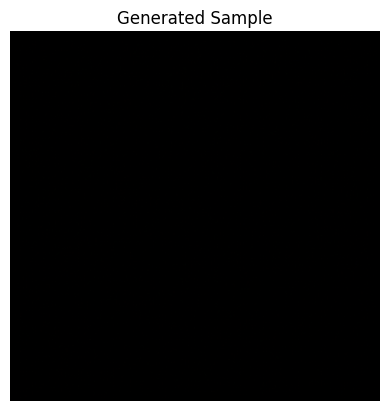

In [44]:
import matplotlib.pyplot as plt

random_latent_vector = tf.random.normal(shape=(1, 128))
generated_sample = generator(random_latent_vector, training=False)
plt.imshow(generated_sample.numpy().reshape(256, 256, 3), cmap='gray')
plt.title('Generated Sample')
plt.axis('off')
plt.show()

In [45]:
def discriminatorModel(image_shape, num_classes):
  model = models.Sequential()

  model.add(layers.Conv2D(64, 3, 2, padding='same', input_shape=input_shape))
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Conv2D(128, 3, 2, padding='same'))
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Conv2D(256, 3, 2, padding='same'))
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Flatten())
  model.add(layers.Dense(num_classes, activation='softmax'))

  return model

discriminator = discriminatorModel((256, 256, 3), 8)
discriminator.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_43 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 32, 32, 256)       295168    
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 32, 32, 256)       0         
                                                                 
 flatten_7 (Flatten)         (None, 262144)          

In [46]:
discriminator.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
fake_sample = generator(tf.random.normal(shape=(1, 128)), training=False)
disPred = discriminator(fake_sample, training=False)

In [48]:
disPred

<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[0.12504978, 0.12499851, 0.12500109, 0.12498709, 0.12503432,
        0.12497984, 0.12500875, 0.12494057]], dtype=float32)>

In [49]:
def GAN(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model


In [50]:
img_shape = (256, 256, 3)
latent_dim = 128
num_classes = 8

In [51]:
gan = GAN(generator, discriminator)
gan.compile(loss='categorical_crossentropy', optimizer='adam')

In [58]:
import numpy as np
# Function to train the GAN
def train_gan(generator, discriminator, gan, train_dataset, latent_dim, epochs=100, batch_size=32):
    for epoch in range(epochs):
        for images, _ in train_dataset:
            batch_size = images.shape[0]

            # Train discriminator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            generated_images = generator.predict(noise)
            real_images = images.numpy()

            fake_labels = np.zeros((batch_size, num_classes))
            real_labels = np.ones((batch_size, num_classes))

            d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

            # Train generator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            valid_labels = np.ones((batch_size, num_classes))
            g_loss = gan.train_on_batch(noise, valid_labels)

        # Print progress
        print(f"Epoch {epoch+1}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

        # Save generated images at some intervals
        if epoch % 10 == 0:
            save_generated_images(epoch, generator)


def save_generated_images(epoch, generator, latent_dim=128, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch}.png')

In [61]:
data_dir = '/content/skin-disease/skin-disease-datasaet/train_set'
img_size = (256, 256)
batch_size = 16

train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=1337,
    image_size=img_size,
    batch_size=batch_size,
)

train_dataset = train_dataset.map(lambda x, y: (tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)(x), y))


Found 924 files belonging to 8 classes.


In [ ]:
train_gan(generator, discriminator, gan, train_dataset, latent_dim, epochs=10, batch_size=16)